# Welcome to Daily Climate Timeseries Model

### Import all dependencies

In [1]:
pip install pydot==1.3.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install graphviz==0.10.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
from keras import callbacks
from keras.layers import Dense, LSTM
from keras.utils import plot_model

### Import Dataset

In [4]:
data_train = pd.read_csv('./datasets/DailyDelhiClimateTrain.csv')

In [5]:
data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


### Preprocessing

##### Check Null Value in dataset

In [7]:
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

##### Data Visualization

In [8]:
dates = data_train['date'].values
temp  = data_train['meantemp'].values

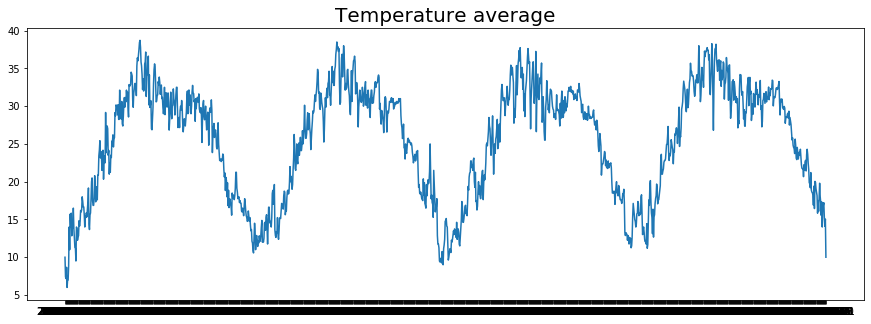

In [9]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

#### windowed dataset function

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

#### Convert the timeseries attributes into numpy

In [11]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)

### Create Model

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [13]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

### Create Callbacks

In [14]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<2.0):
      print("\nYour Loss < 2.0!")
      self.model.stop_training = True

In [15]:
callbacks = myCallback()

### Fit Model

In [16]:
history = model.fit(train_set, epochs=100, callbacks=[callbacks])

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 2s 102ms/step - loss: 25.2949 - mae: 25.7949
Epoch 2/100
15/15 [==============================] - 2s 111ms/step - loss: 25.2043 - mae: 25.7043
Epoch 3/100
15/15 [==============================] - 2s 119ms/step - loss: 25.0931 - mae: 25.5931
Epoch 4/100
15/15 [==============================] - 1s 97ms/step - loss: 24.9804 - mae: 25.4804
Epoch 5/100
15/15 [==============================] - 1s 97ms/step - loss: 24.8536 - mae: 25.3536
Epoch 6/100
15/15 [=

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  14880     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  29040     
_________________________________________________________________
dense (Dense)                multiple                  1830      
_________________________________________________________________
dense_1 (Dense)              multiple                  310       
_________________________________________________________________
dense_2 (Dense)              multiple                  11        
Total params: 46,071
Trainable params: 46,071
Non-trainable params: 0
_________________________________________________________________
None


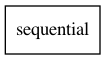

In [18]:
plot_model(model, to_file='10-daily-climate-timeseries.png')

### Plotting

#### Plot Model Loss

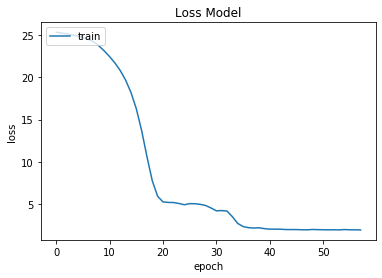

In [19]:
plt.plot(history.history['loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Plot Model MAE

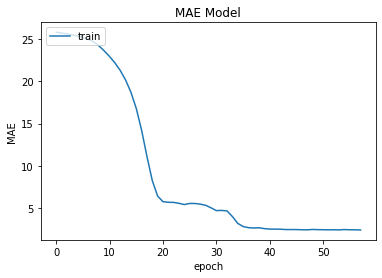

In [20]:
plt.plot(history.history['mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()